# Portfolio Management


**Objective:** In this project, we aim to build stylized long-short equity factor mimicking portfolios using different fundamental variables from Ken French’s data library and explore empirically their univariate efficacy over time and across different size segments. We then go on to build multi-factor strategies using alternative weighting schemes and compare them to the static equally weighted multi-factor strategy. Two alternative top-down factor weighting schemes will be considered: 
1. Equal risk contribution across factors 
2. Weighting based on factor persistence

**Data:** Attached with the project description are 6 csv files containing the monthly time series of value- and equal-weighted returns for portfolios formed on size and different fundamental variables consisting of **book-to-price, cashflow-to-price, dividend yield, investment, profitability, prior 1-month return and 12-1 price momentum**. In addition, there is a csv file named “F-F_Research_Data_Factors” which houses the Fama-French 3 factor model returns.

In [100]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
# Book-to-price ratio - Value-weighted & equal-weighted portfolios
value_bp = pd.read_csv('6_Portfolios_ME_BP_2x3.csv', skiprows=15, nrows=1101, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
equal_bp = pd.read_csv('6_Portfolios_ME_BP_2x3.csv', skiprows=1120, nrows=1101, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))

# Cashflow-to-price - Value-weighted & equal-weighted portfolios
value_cfp = pd.read_csv('6_Portfolios_ME_CFP_2x3.csv', skiprows=19, nrows=801, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
equal_cfp = pd.read_csv('6_Portfolios_ME_CFP_2x3.csv', skiprows=824, nrows=801, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))

# Dividend Yield - Value-weighted & equal-weighted portfolios
value_dp = pd.read_csv('6_Portfolios_ME_DP_2x3.csv', skiprows=19, nrows=1089, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
equal_dp = pd.read_csv('6_Portfolios_ME_DP_2x3.csv', skiprows=1112, nrows=1089, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))

# Profitability - Value-weighted & equal-weighted portfolios
value_pro = pd.read_csv('6_Portfolios_ME_OP_2x3.csv', skiprows=16, nrows=657, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
equal_pro = pd.read_csv('6_Portfolios_ME_OP_2x3.csv', skiprows=677, nrows=657, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))

# 12-1 price momentum - Value-weighted & equal-weighted portfolios
value_mo = pd.read_csv('6_Portfolios_ME_Prior_12_2.csv', skiprows=11, nrows=1095, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
equal_mo = pd.read_csv('6_Portfolios_ME_Prior_12_2.csv', skiprows=1110, nrows=1095, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))


In [102]:
# Note: lambda function reorders columns of the following dataframes so that lo minus hi is carried out. This is simply for ease.
reorder = lambda x: x[[x.columns[2],x.columns[1],x.columns[0],x.columns[5],x.columns[4],x.columns[3]]]

# Investment - Value-weighted & equal-weighted portfolios
value_inv = pd.read_csv('6_Portfolios_ME_INV_2x3.csv', skiprows=16, nrows=657, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
equal_inv = pd.read_csv('6_Portfolios_ME_INV_2x3.csv', skiprows=677, nrows=657, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
value_inv, equal_inv = reorder(value_inv), reorder(equal_inv)

# Prior 1-month return - Value-weighted & equal-weighted portfolios
value_prior = pd.read_csv('6_Portfolios_ME_Prior_1_0.csv', skiprows=11, nrows=1106, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
equal_prior = pd.read_csv('6_Portfolios_ME_Prior_1_0.csv', skiprows=1121, nrows=1106, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
value_prior, equal_prior = reorder(value_prior), reorder(equal_prior)

# fama french data factors
ff = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3, nrows=1101, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))


In [ ]:
# synchronizing every time series to start at the same date (the time series with the latest start date)
value_weight = [value_bp, value_cfp, value_dp, value_inv, value_pro, value_prior, value_mo]
latest_start_val = max([value_weight[i].index[0] for i in range(7)]) # find the time series with the latest date

In [105]:
value_weight

[            SMALL LoBM  ME1 BM2  SMALL HiBM  BIG LoBM  ME2 BM2  BIG HiBM
 1963-07-01     -1.0781  -0.6144     -1.1362   -0.0296   0.4469   -1.5958
 1963-08-01      4.4508   4.4668      5.7397    5.4037   4.6832    7.4085
 1963-09-01     -3.0662  -0.5101     -1.9250   -1.0508  -1.7302   -1.8068
 1963-10-01      1.1622   1.7315      2.7180    3.8602   1.2408    2.1338
 1963-11-01     -2.8656  -1.2746     -0.3262   -0.2513  -1.4568    0.6280
 ...                ...      ...         ...       ...      ...       ...
 2017-11-01      2.4043   2.8135      2.6792    3.4529   3.1135    3.2194
 2017-12-01      0.8497  -0.6541      0.0773    0.9424   1.2116    1.9324
 2018-01-01      3.1918   3.0639      1.7192    6.6576   5.2027    5.3057
 2018-02-01     -3.0855  -3.6430     -3.8733   -2.4756  -4.8757   -4.0924
 2018-03-01      1.1207   0.9226      1.9486   -2.2887  -2.3055   -3.2793
 
 [657 rows x 6 columns],
             SMALL LoCFP  ME1 CFP2  SMALL HiCFP  BIG LoCFP  ME2 CFP2  BIG HiCFP
 1963

In [99]:
value_weight = [value_weight[i][value_weight[i].index.get_loc(latest_start_val):] for i in range(7)]

equal_weight = [equal_bp, equal_cfp, equal_dp, equal_inv, equal_pro, equal_prior, equal_mo]
latest_start_eq = max([value_weight[i].index[0] for i in range(7)]) # find the time series with the latest date
equal_weight = [equal_weight[i][equal_weight[i].index.get_loc(latest_start_eq):] for i in range(7)]

fundamental_title = ['Book-to-Price', 'Cash-to-Price', 'Dividend Yield', 'Investment', 'Profitability', 'Prior Month Return', '12-1 Momentum']

TypeError: float() argument must be a string or a number, not 'Timestamp'

### Task 1:
a) For each of the six fundamental variables, construct long-short factor mimicking portfolios and plot their historical performance across different size segments. <br>

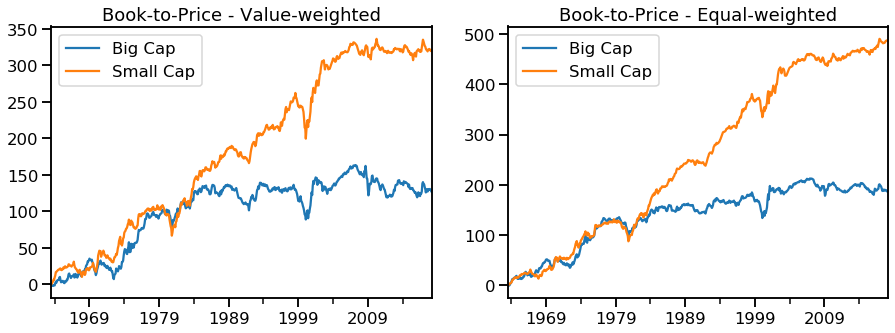

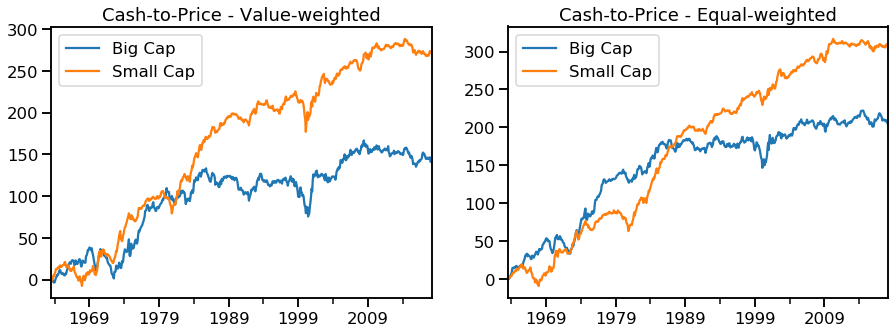

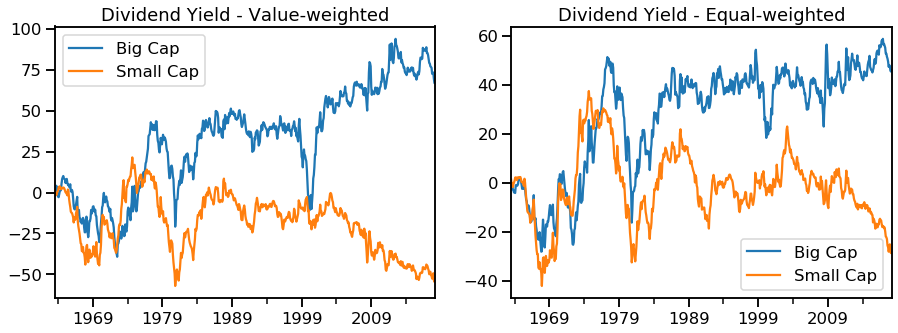

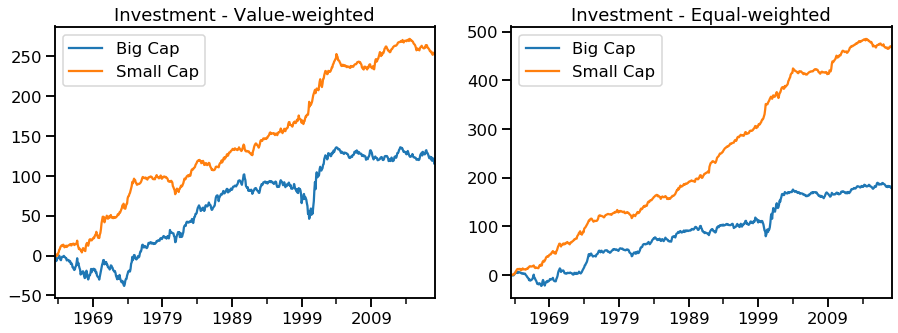

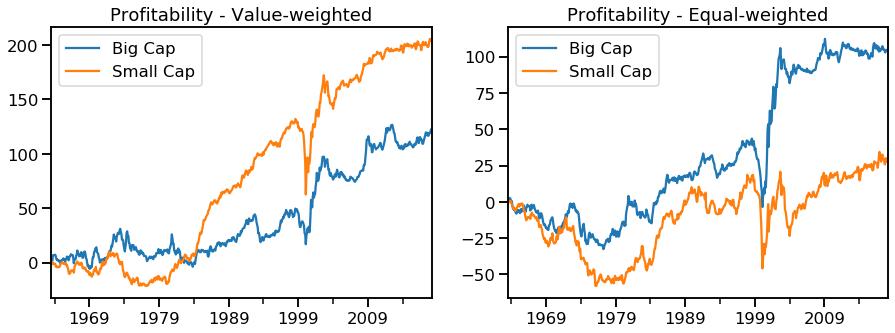

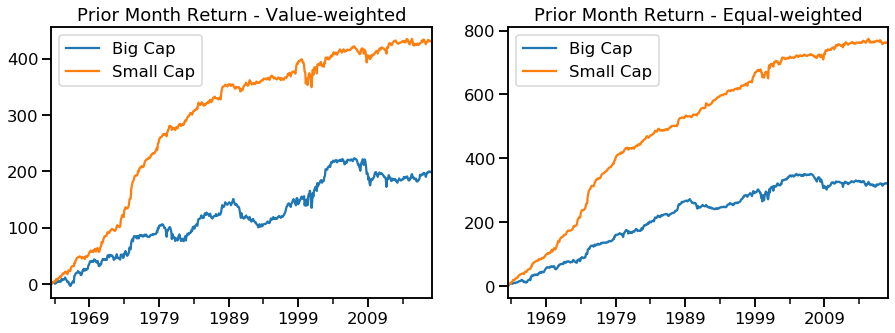

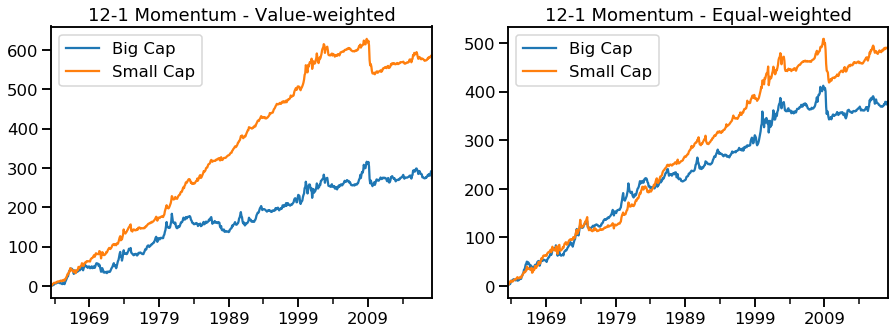

[None, None, None, None, None, None, None]

In [20]:
%matplotlib inline
# hi minus lo except for Investment & Prior month return - lo minus hi
f = lambda x, y: (x - y).cumsum() # cumulative sum
sns.set_context('talk')

def long_short(x,y,title):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    time_series_1 = pd.DataFrame({'Big Cap': f(x.iloc[:,5],x.iloc[:,3]), 'Small Cap': f(x.iloc[:,2],x.iloc[:,0])}) # low minus high
    time_series_2 = pd.DataFrame({'Big Cap': f(y.iloc[:,5],y.iloc[:,3]), 'Small Cap': f(y.iloc[:,2],y.iloc[:,0])})
    time_series_1.plot(ax=axs[0], title=title + ' - Value-weighted')
    time_series_2.plot(ax=axs[1], title=title + ' - Equal-weighted')  
    return plt.show()

[long_short(value_weight[i],equal_weight[i],fundamental_title[i]) for i in range(7)]

<font color='blue'><b>Comments:</b>
RMWt is the difference between the returns on diversified portfolios of stocks with robust and weak profitability, and CMAt is the difference between the returns on diversified portfolios of low and high investment stocks (Fama, French 2014)</font>

b) Taking the market return from Fama-French’s 3-factor model, calculate and plot the rolling 3-year market beta for these stylized portfolios. <br>

In [80]:
import statsmodels.api as sm

# note, this regression carries out a rolling window of 3 years
def regress(dataframe):
    
    # for the sake of not changing original dataframe
    df = dataframe 
    french = ff
    # to verify longer dataframe & match range of dates
    if len(ff) > len(df):
        french = ff[(ff.index >= df.index[0])]
        print (french.columns)
    else:
        df = df[(df.index >= ff.index[0])]
    
    # after range of dates are equal, regression is carried out
    excess_ret = sm.add_constant(french['Mkt-RF'])
    small_hi_alpha, small_lo_alpha, big_hi_alpha, big_lo_alpha  = [], [], [], []
    small_hi_beta, small_lo_beta, big_hi_beta, big_lo_beta = [], [], [], []
    # returns minus risk-free rate, thereafter regression is run in a 3-year rolling window
    for i in np.arange(0,len(df)+1,1):
        small_hi, small_lo, big_hi, big_lo = df.iloc[:,2][i:i+36] - french.iloc[:,3][i:i+36], \
        df.iloc[:,0][i:i+36] - french.iloc[:,3][i:i+36], df.iloc[:,5][i:i+36] - french.iloc[:,3][i:i+36], \
        df.iloc[:,3][i:i+36] - french.iloc[:,3][i:i+36]
        
        # small cap hi
        if len(small_hi) == 36: #ensuring that range is 36 months
            est_1 = sm.OLS(small_hi, excess_ret[i:i+36]).fit()
            small_hi_alpha.append(est_1.params[0]); small_hi_beta.append(est_1.params[1])
        # small cap lo
        if len(small_lo) == 36: #ensuring that range is 36 months
            est_2 = sm.OLS(small_lo, excess_ret[i:i+36]).fit()
            small_lo_alpha.append(est_2.params[0]); small_lo_beta.append(est_2.params[1])
        # big cap hi
        if len(big_hi) == 36: #ensuring that range is 36 months
            est_3 = sm.OLS(big_hi, excess_ret[i:i+36]).fit()
            big_hi_alpha.append(est_3.params[0]); big_hi_beta.append(est_3.params[1])
        # big cap lo
        if len(big_lo) == 36: #ensuring that range is 36 months
            est_4 = sm.OLS(big_lo, excess_ret[i:i+36]).fit()
            big_lo_alpha.append(est_4.params[0]); big_lo_beta.append(est_4.params[1])
            
    table = pd.DataFrame({'small_hi_alpha': small_hi_alpha, 'small_lo_alpha': small_lo_alpha,\
                          'big_hi_alpha': big_hi_alpha, 'big_lo_alpha': big_lo_alpha,\
                          'small_hi_beta': small_hi_beta, 'small_lo_beta': small_lo_beta,\
                          'big_hi_beta': big_hi_beta, 'big_lo_beta': big_lo_beta,'date': df.iloc[:,0][35:len(df)]})
    

    return table.drop(columns=['date'])

In [106]:
# function to plot out market betas
def mkt_beta(value,equal,title):
    value_coef, equal_coef = regress(value), regress(equal) # running function regress
    value_beta, equal_beta = pd.DataFrame({'beta_small': value_coef['small_hi_beta'] - value_coef['small_lo_beta'], 
                                           'beta_big': value_coef['big_hi_beta'] - value_coef['big_lo_beta']}), \
    pd.DataFrame({'beta_small': equal_coef['small_hi_beta'] - equal_coef['small_lo_beta'], 
                                           'beta_big': equal_coef['big_hi_beta'] - equal_coef['big_lo_beta']})
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    value_beta[['beta_small', 'beta_big']].plot(ax=axs[0], title=title + ' - Value-weighted')
    equal_beta[['beta_small', 'beta_big']].plot(ax=axs[1], title=title + ' - Equal-weighted')
    return plt.show()

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


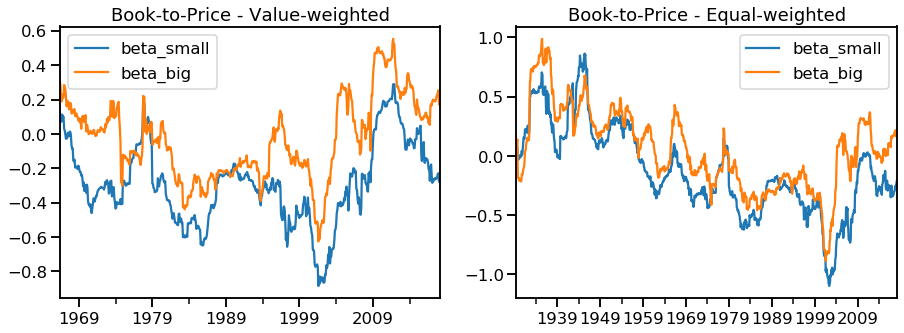

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


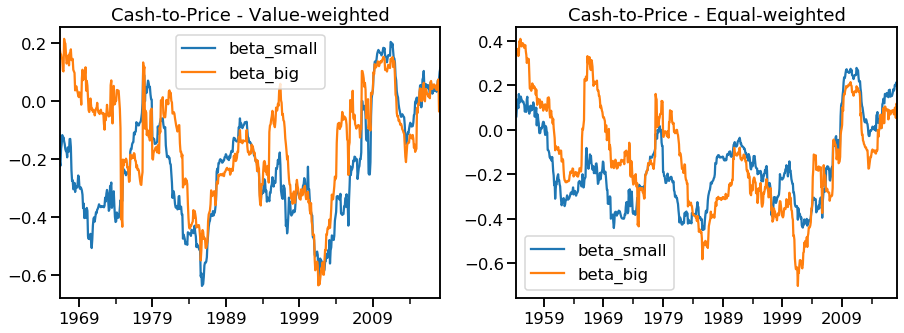

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


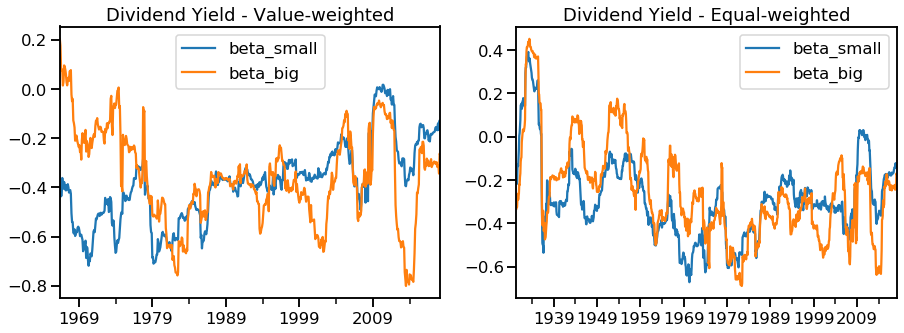

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


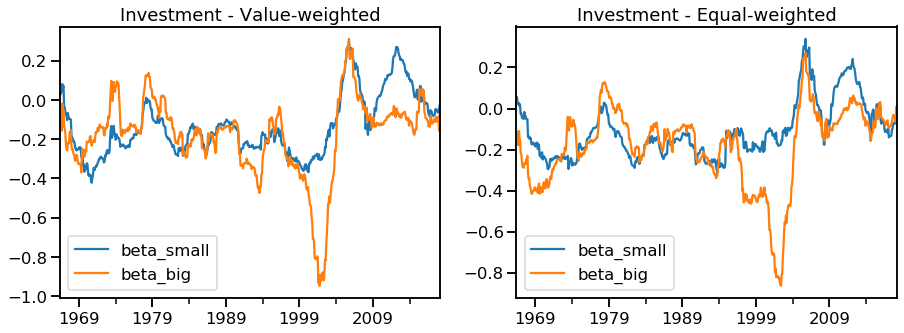

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


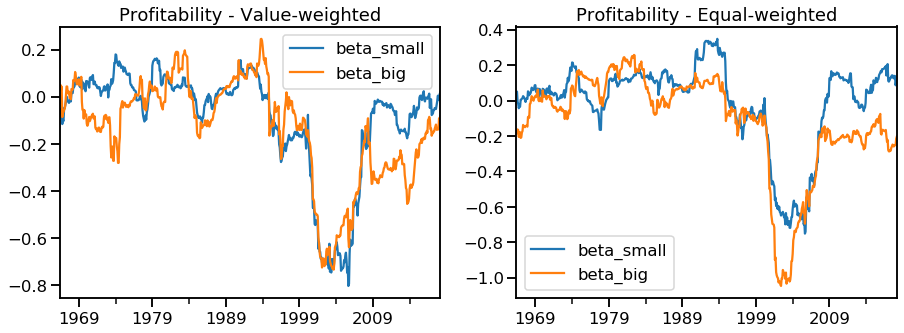

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


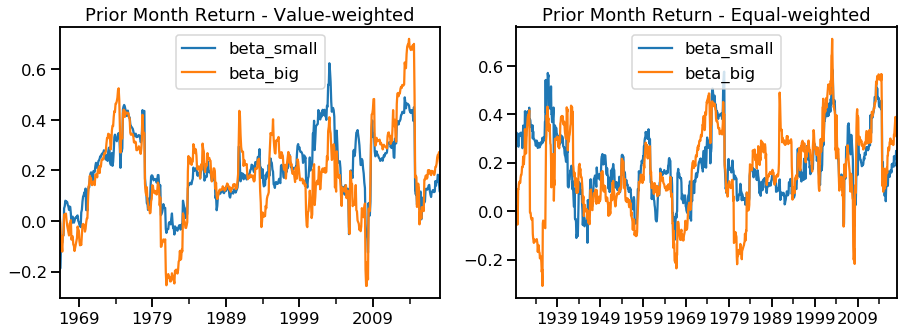

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


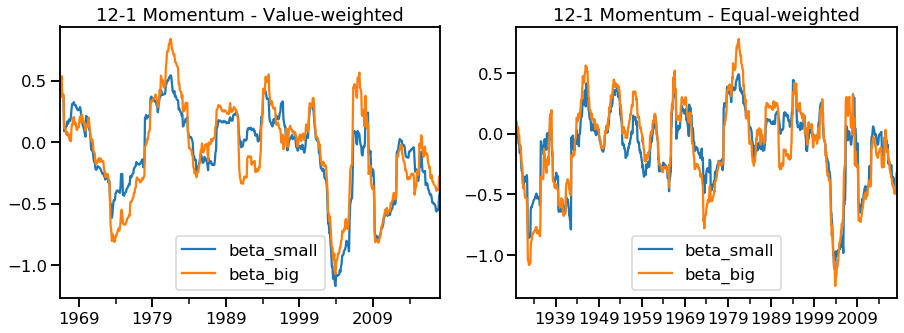

[None, None, None, None, None, None, None]

In [107]:
# subplots
[mkt_beta(value_weight[i],equal_weight[i],fundamental_title[i]) for i in range(7)]

c) Considering both size segments, construct a beta-neutral factor mimicking portfolio for each fundamental variable. Comment on your results. 

In [83]:
# Visit cvxpy.org, install cvxpy with conda:
# conda install -c conda-forge lapack
# conda install -c cvxgrp cvxpy

import cvxpy as cvx
from cvxpy import *

In [84]:
regress(equal_weight[0]).head()

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


,small_hi_alpha,small_lo_alpha,big_hi_alpha,big_lo_alpha,small_hi_beta,small_lo_beta,big_hi_beta,big_lo_beta
1966-06-01,0.958350,0.347505,0.352163,-0.020009,1.398671,1.334494,1.371389,0.956104
1966-07-01,1.006629,0.333040,0.402791,-0.003485,1.390437,1.342749,1.363743,0.952167
1966-08-01,1.050599,0.350458,0.484496,-0.064697,1.497007,1.500197,1.338580,0.986113
1966-09-01,1.025655,0.296740,0.493901,-0.039895,1.500606,1.510176,1.334304,0.978913
1966-10-01,0.889782,0.075358,0.499212,-0.056970,1.396012,1.353641,1.324883,0.960129


In [108]:
def optimize(regressed_df):
    
    w_big_lo, w_small_lo, w_big_hi, w_small_hi = [], [], [], []
    agg_alpha = []
    status = []
    lambd = 0.1 # cash reserve as a proportion of shorting stocks
    
    for i in np.arange(0,len(regressed_df),1): # len(df)-1
        
        # cvx variables of individual weights
        p1 = cvx.Variable() # short big cap lo weight
        p2 = cvx.Variable() # short small cap lo weight
        p3 = cvx.Variable() # long big cap hi weight
        p4 = cvx.Variable() # long small cap hi weight
        
        # sum of weight * beta = 0, p3 + p4 - 0.1*(p1 + p2) == 1
        constraints = [p1 <= 0, p2 <= 0, p3 >= 0, p4 >= 0,\
                       sum([p3*regressed_df['big_hi_beta'][i], p4*regressed_df['small_hi_beta'][i], \
                            p1*regressed_df['big_lo_beta'][i], p2*regressed_df['small_lo_beta'][i]]) == 0,\
                       p3 + p4 - 0.1*(p1 + p2) == 1] #
        
        obj = cvx.Maximize(sum([p1*regressed_df['big_lo_alpha'][i], p2*regressed_df['small_lo_alpha'][i], \
                                p3*regressed_df['big_hi_alpha'][i], p4*regressed_df['small_hi_alpha'][i]]))
        prob = cvx.Problem(obj, constraints)
        prob.solve()  # Returns the optimal value.
        #print("status:", prob.status)
        #print("optimal value", prob.value)
        #print("optimal var", p1.value, p2.value, p3.value, p4.value)
        status.append(prob.status); agg_alpha.append(prob.value); w_big_lo.append(p1.value); \
        w_small_lo.append(p2.value); w_big_hi.append(p3.value); w_small_hi.append(p4.value)
        
    weights_table = pd.DataFrame({'status': status, 'agg_alpha': agg_alpha, 'w_big_lo': w_big_lo, \
                                  'w_small_lo': w_small_lo, 'w_big_hi': w_big_hi, 'w_small_hi': w_small_hi})
    return weights_table

In [109]:
mean_smallHi, mean_bigHi, mean_smallLo, mean_bigLo = [], [], [], []
stdd_smallHi, stdd_bigHi, stdd_smallLo, stdd_bigLo = [], [], [], []

for i in np.arange(0,len(equal_weight[0]),1):
    mean_smallHi.append(equal_weight[0].iloc[:,2][i:i+36].mean()); stdd_smallHi.append(equal_weight[0].iloc[:,2][i:i+36].std())
    mean_bigHi.append(equal_weight[0].iloc[:,5][i:i+36].mean()); stdd_bigHi.append(equal_weight[0].iloc[:,5][i:i+36].std())
    mean_smallLo.append(equal_weight[0].iloc[:,0][i:i+36].mean()); stdd_smallLo.append(equal_weight[0].iloc[:,0][i:i+36].std())
    mean_bigLo.append(equal_weight[0].iloc[:,3][i:i+36].mean()); stdd_bigLo.append(equal_weight[0].iloc[:,3][i:i+36].std())
    


In [110]:
"""def optimize_sr(regressed_df, df):
    
    rf_rate = ff.iloc[:,3][36:len(df)] # risk-free rate
    df = df[36:]
    
    w_big_lo, w_small_lo, w_big_hi, w_small_hi = [], [], [], []
    agg_alpha = []
    status = []
    lambd = 0.1 # cash reserve as a proportion of shorting stocks
    
    for i in np.arange(0,len(df),1): # len(df)-1
        
        # cvx variables of individual weights
        p1 = cvx.Variable() # short big cap lo weight
        p2 = cvx.Variable() # short small cap lo weight
        p3 = cvx.Variable() # long big cap hi weight
        p4 = cvx.Variable() # long small cap hi weight
        
        # sum of weight * beta = 0, p3 + p4 - 0.1*(p1 + p2) == 1
        constraints = [p1 <= 0, p2 <= 0, p3 >= 0, p4 >= 0,\
                       sum([p3*regressed_df['big_hi_beta'][i], p4*regressed_df['small_hi_beta'][i], \
                            p1*regressed_df['big_lo_beta'][i], p2*regressed_df['small_lo_beta'][i]]) == 0,\
                       p3 + p4 - 0.1*(p1 + p2) == 1] #
        
        obj = cvx.Maximize(sum([p1*regressed_df['big_lo_alpha'][i], p2*regressed_df['small_lo_alpha'][i], \
                                p3*regressed_df['big_hi_alpha'][i], p4*regressed_df['small_hi_alpha'][i]]))
        prob = cvx.Problem(obj, constraints)
        prob.solve()  # Returns the optimal value.
        #print("status:", prob.status)
        #print("optimal value", prob.value)
        #print("optimal var", p1.value, p2.value, p3.value, p4.value)
        status.append(prob.status); agg_alpha.append(prob.value); w_big_lo.append(p1.value); \
        w_small_lo.append(p2.value); w_big_hi.append(p3.value); w_small_hi.append(p4.value)
        
    weights_table = pd.DataFrame({'status': status, 'agg_alpha': agg_alpha, 'w_big_lo': w_big_lo, \
                                  'w_small_lo': w_small_lo, 'w_big_hi': w_big_hi, 'w_small_hi': w_small_hi})
    return weights_table"""

'def optimize_sr(regressed_df, df):\n    \n    rf_rate = ff.iloc[:,3][36:len(df)] # risk-free rate\n    df = df[36:]\n    \n    w_big_lo, w_small_lo, w_big_hi, w_small_hi = [], [], [], []\n    agg_alpha = []\n    status = []\n    lambd = 0.1 # cash reserve as a proportion of shorting stocks\n    \n    for i in np.arange(0,len(df),1): # len(df)-1\n        \n        # cvx variables of individual weights\n        p1 = cvx.Variable() # short big cap lo weight\n        p2 = cvx.Variable() # short small cap lo weight\n        p3 = cvx.Variable() # long big cap hi weight\n        p4 = cvx.Variable() # long small cap hi weight\n        \n        # sum of weight * beta = 0, p3 + p4 - 0.1*(p1 + p2) == 1\n        constraints = [p1 <= 0, p2 <= 0, p3 >= 0, p4 >= 0,                       sum([p3*regressed_df[\'big_hi_beta\'][i], p4*regressed_df[\'small_hi_beta\'][i],                             p1*regressed_df[\'big_lo_beta\'][i], p2*regressed_df[\'small_lo_beta\'][i]]) == 0,                       p

In [111]:
def sum_of_betas(df, title):
    beta_values = regress(df).reset_index()
    beta_weights_ = optimize(regress(df))
    beta_times_weights = beta_values['big_hi_beta'] * beta_weights_['w_big_hi'] + \
    beta_values['small_hi_beta'] * beta_weights_['w_small_hi'] + \
    beta_values['big_lo_beta'] * beta_weights_['w_big_lo'] + \
    beta_values['small_lo_beta'] * beta_weights_['w_small_lo']
    
    total_weights_table = pd.DataFrame({'Date': beta_values['index'], 'sum beta weights': beta_times_weights})
    total_weights_table.set_index('Date', inplace = True)
    print (total_weights_table)
    plt.figure(figsize=(15,5))
    plt.plot(total_weights_table)
    plt.title('Sum of beta weights' + ' - ' + title)
    return plt.show()

           sum beta weights
Date                       
1929-06-01        0.0874055
1929-07-01     -9.65894e-15
1929-08-01     -4.77396e-15
1929-09-01     -1.77636e-15
1929-10-01     -2.22045e-15
...                     ...
2017-11-01     -7.77156e-16
2017-12-01     -8.88178e-16
2018-01-01     -8.88178e-16
2018-02-01     -8.88178e-16
2018-03-01     -7.77156e-16

[1066 rows x 1 columns]


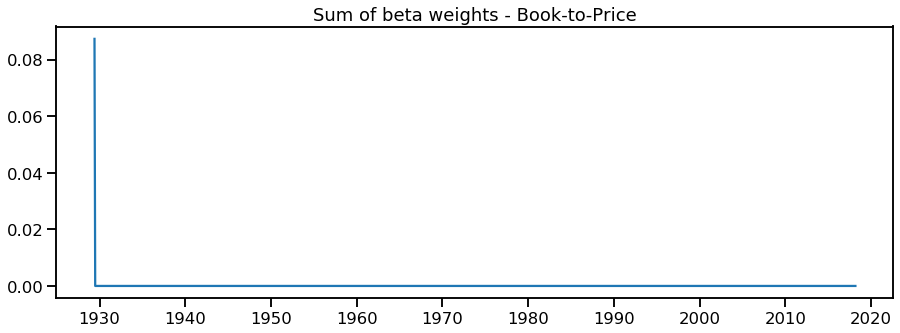

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
           sum beta weights
Date                       
1954-06-01       -0.0733157
1954-07-01      4.44089e-15
1954-08-01      9.99201e-16
1954-09-01      3.33067e-16
1954-10-01      1.77636e-15
...                     ...
2017-11-01      1.27009e-16
2017-12-01                0
2018-01-01     -4.98932e-14
2018-02-01     -3.98719e-17
2018-03-01      -1.3214e-16

[766 rows x 1 columns]


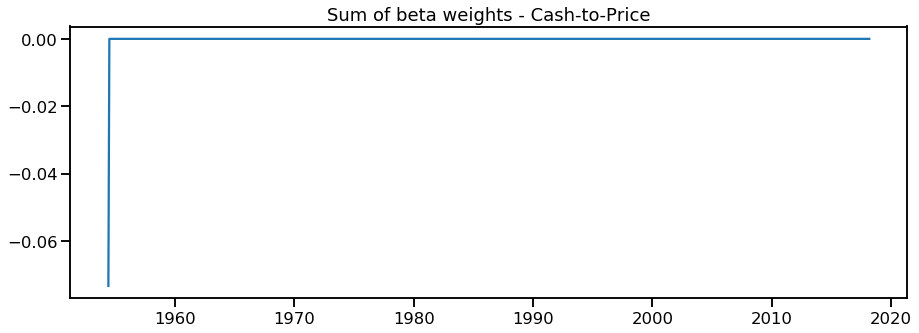

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
           sum beta weights
Date                       
1930-06-01        0.0441875
1930-07-01                0
1930-08-01     -5.44009e-15
1930-09-01      8.54872e-15
1930-10-01     -4.10783e-15
...                     ...
2017-11-01     -1.40369e-14
2017-12-01     -1.06476e-14
2018-01-01     -1.06194e-14
2018-02-01      -4.7834e-15
2018-03-01     -9.69783e-15

[1054 rows x 1 columns]


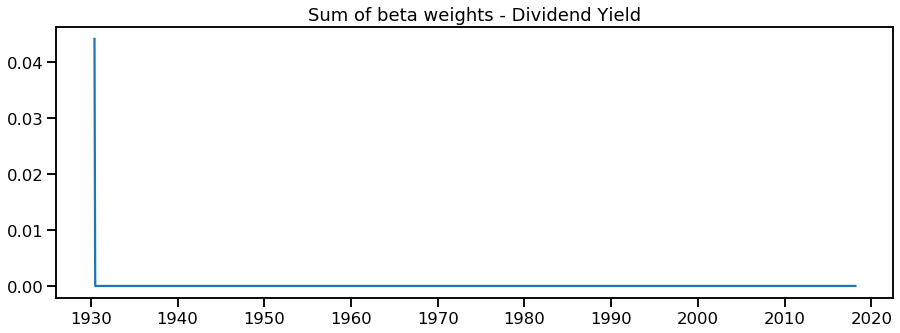

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
           sum beta weights
Date                       
1966-06-01         0.221503
1966-07-01     -1.70161e-14
1966-08-01     -2.04221e-14
1966-09-01     -1.32384e-14
1966-10-01     -1.32134e-14
...                     ...
2017-11-01      5.55112e-15
2017-12-01     -2.66454e-15
2018-01-01     -1.77636e-15
2018-02-01     -2.22045e-16
2018-03-01     -1.11022e-15

[622 rows x 1 columns]


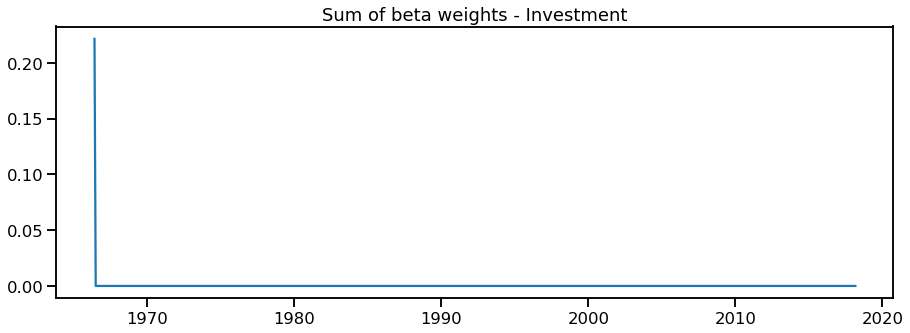

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
           sum beta weights
Date                       
1966-06-01        -0.250247
1966-07-01     -3.73182e-15
1966-08-01     -8.70973e-15
1966-09-01     -7.71362e-15
1966-10-01     -2.14165e-15
...                     ...
2017-11-01      7.32747e-15
2017-12-01     -1.22125e-15
2018-01-01     -1.22125e-15
2018-02-01     -1.11022e-16
2018-03-01      1.88738e-15

[622 rows x 1 columns]


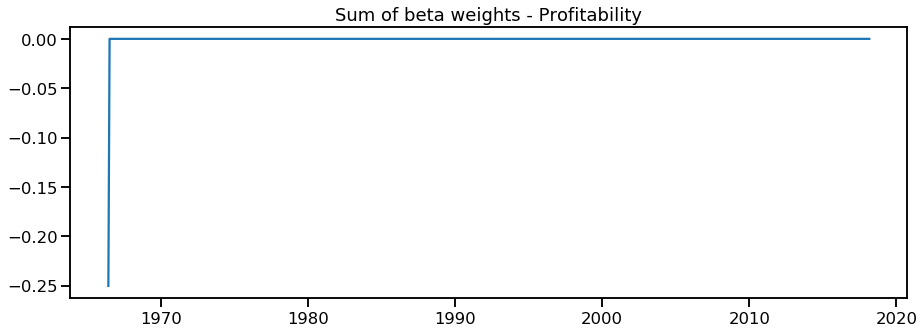

           sum beta weights
Date                       
1929-06-01        -0.038901
1929-07-01     -8.65974e-15
1929-08-01      -3.9968e-15
1929-09-01     -7.32747e-15
1929-10-01     -2.88658e-15
...                     ...
2017-11-01     -4.44089e-16
2017-12-01                0
2018-01-01     -2.22045e-16
2018-02-01     -8.88178e-16
2018-03-01     -2.44249e-15

[1066 rows x 1 columns]


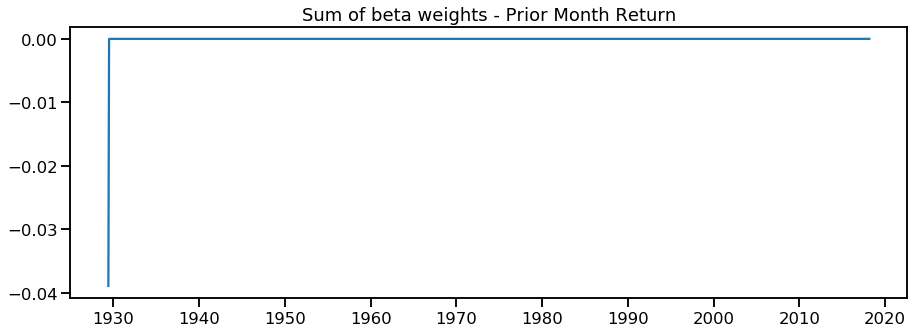

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')
           sum beta weights
Date                       
1929-12-01        -0.288995
1930-01-01      -4.0345e-15
1930-02-01     -1.74754e-15
1930-03-01     -3.40401e-16
1930-04-01      1.29059e-16
...                     ...
2017-11-01      9.21485e-15
2017-12-01      6.55032e-15
2018-01-01      1.79503e-11
2018-02-01      1.21014e-14
2018-03-01      9.99201e-15

[1060 rows x 1 columns]


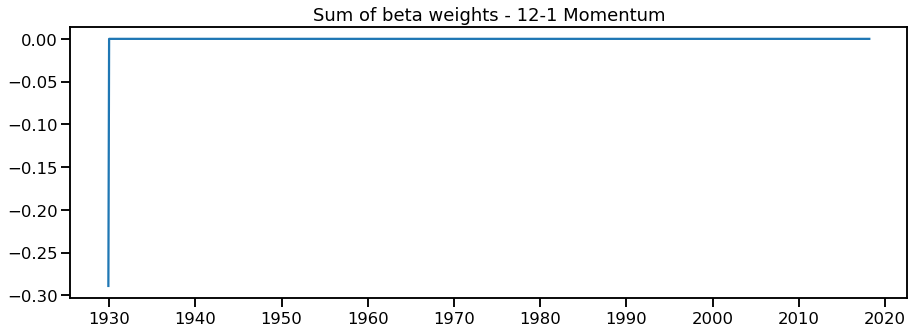

In [112]:
for i in range(7):
    sum_of_betas(equal_weight[i],fundamental_title[i])

In [122]:
def beta_neutral(df):
    betaWghts = optimize(regress(df)) # regressing to get beta coefficients & optimizing to get weights of betas
    # there are issues with multiplying columns of 2 diff dataframes with datetime index, hence datetime is pushed out of index
    readj_df = df.iloc[36:len(df)].reset_index() # initially put +1
    print (readj_df.shape)
    print (readj_df.head(3))
    print (readj_df.columns)
    
    f = lambda x, y: (x - y).cumsum() # hi minus lo

    # beta neutral returns = (beta wt * big_hi + beta wt * small_hi) - (beta wt * big_lo + beta wt * small_lo)
    beta_portfolio_hi = (betaWghts['w_big_hi'] * readj_df.iloc[:,6]) + (betaWghts['w_small_hi'] * readj_df.iloc[:,3])
    beta_portfolio_lo = 0.1 * ((betaWghts['w_big_lo'] * readj_df.iloc[:,4]) + (betaWghts['w_small_lo'] * readj_df.iloc[:,1]))

    rf_rate = ff.iloc[:,3][36:len(df)].reset_index()
    mkt_ret = ff.iloc[:,0][36:len(df)].reset_index()

    betaNeu_vs_ls = pd.DataFrame({'Date': readj_df.iloc[:,0],\
                              'Beta Neutral': f(beta_portfolio_hi,beta_portfolio_lo), \
                              'Big Cap Long-short': f(readj_df.iloc[:,6],readj_df.iloc[:,4]), \
                              'Small Cap Long-short': f(readj_df.iloc[:,3],readj_df.iloc[:,1]),\
                              'Risk-free': f(rf_rate.iloc[:,1],0),\
                                  'Market': f(mkt_ret.iloc[:,1],0) })

    betaNeu_vs_ls.set_index('Date', inplace=True)
    print(betaNeu_vs_ls)
    
    return betaNeu_vs_ls

(1065, 7)
       index  SMALL LoBM  ME1 BM2  SMALL HiBM  BIG LoBM  ME2 BM2  BIG HiBM
0 1929-07-01     -0.7734  -1.5002      1.8839    2.5535   3.4639    4.4962
1 1929-08-01     -1.6700  -0.8035     -1.1398    4.5985   6.7367    5.5394
2 1929-09-01     -6.4324  -4.7872     -5.2314   -2.9218  -3.0819   -4.9902
Index(['index', 'SMALL LoBM', 'ME1 BM2', 'SMALL HiBM', 'BIG LoBM', 'ME2 BM2',
       'BIG HiBM'],
      dtype='object')
           Beta Neutral  Big Cap Long-short  Small Cap Long-short  Risk-free  \
Date                                                                           
1929-07-01      1.94762              1.9427                2.6573       0.33   
1929-08-01      6.79728              2.8836                3.1875       0.73   
1929-09-01      1.66193              0.8152                4.3885       1.08   
1929-10-01      -11.719             12.9665                8.1453       1.54   
1929-11-01     -21.7595             17.3718               10.9558       1.91   
...       

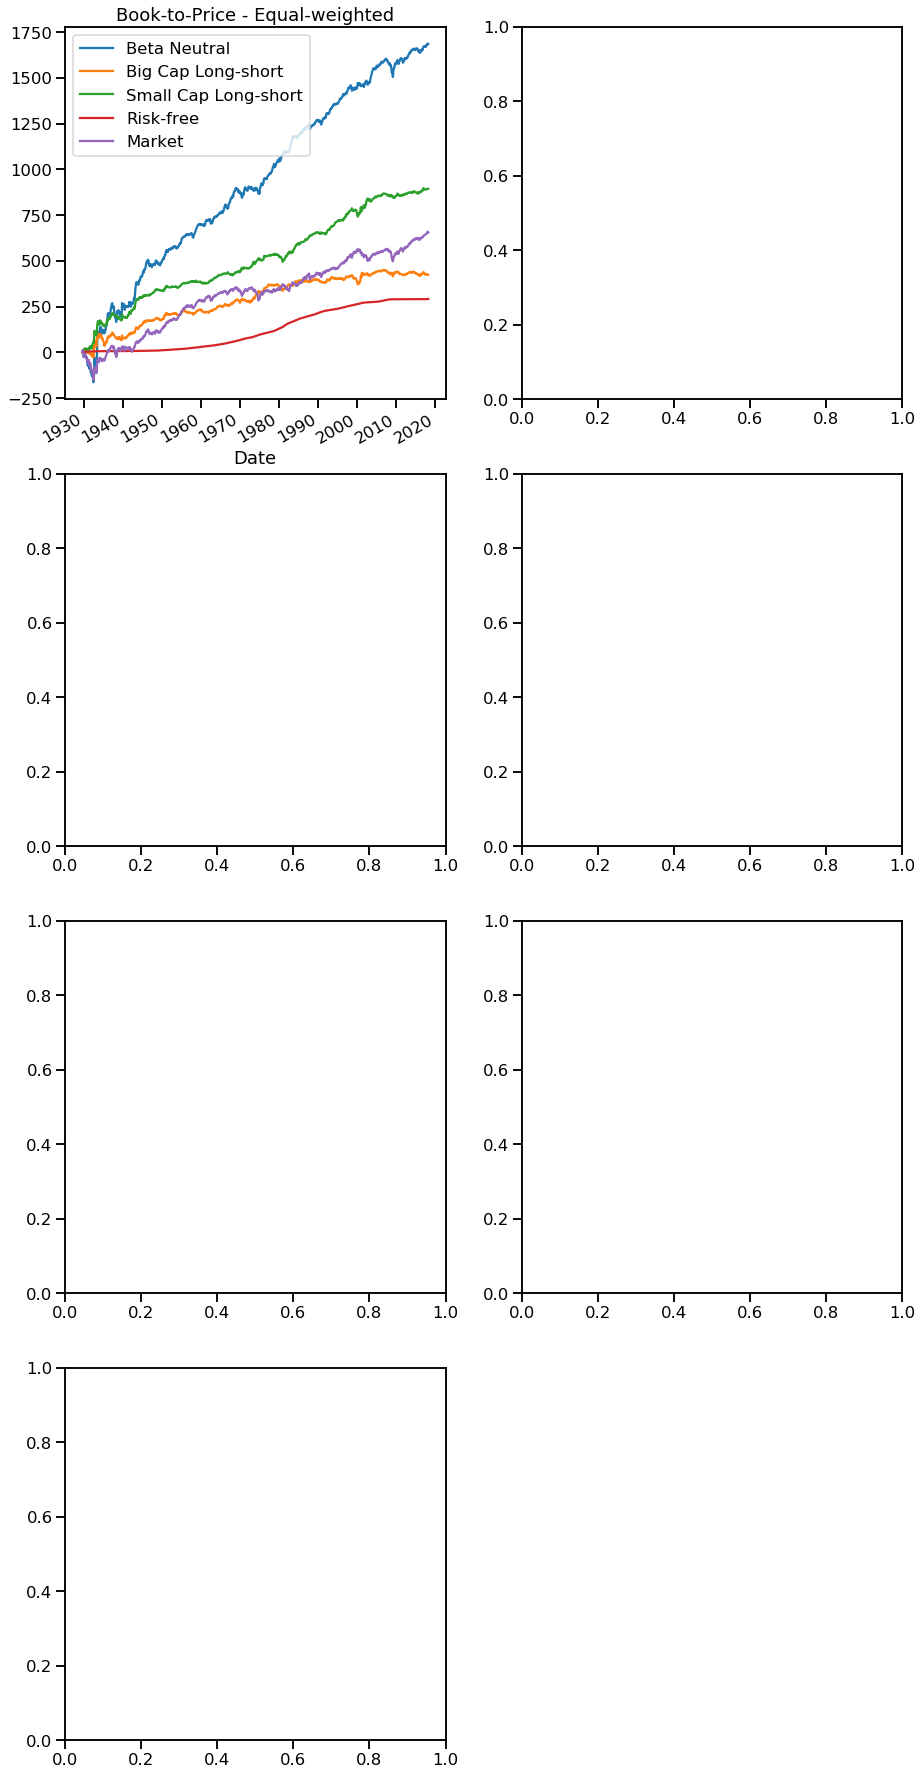

In [123]:
sns.set_context('talk')
fig, axs = plt.subplots(4,2,figsize=(15,35))
fig.delaxes(axs[-1, -1])

beta_neutral(equal_weight[0]).plot(ax=axs[0,0], title= fundamental_title[0] + ' - Equal-weighted')
#beta_neutral(equal_weight[1]).plot(ax=axs[0,1], title= fundamental_title[1] + ' - Equal-weighted')
#beta_neutral(equal_weight[2]).plot(ax=axs[1,0], title= fundamental_title[2] + ' - Equal-weighted')
#beta_neutral(equal_weight[3]).plot(ax=axs[1,1], title= fundamental_title[3] + ' - Equal-weighted')
#beta_neutral(equal_weight[4]).plot(ax=axs[2,0], title= fundamental_title[4] + ' - Equal-weighted')
#beta_neutral(equal_weight[5]).plot(ax=axs[2,1], title= fundamental_title[5] + ' - Equal-weighted')
#beta_neutral(equal_weight[6]).plot(ax=axs[3,0], title= fundamental_title[6] + ' - Equal-weighted')
plt.show()

In [ ]:
def beta_neu_returns(df):
    betaWghts = optimize(regress(df)) # regressing to get beta coefficients & optimizing to get weights of betas
    # there are issues with multiplying columns of 2 diff dataframes with datetime index, hence datetime is pushed out of index
    readj_df = df.iloc[36:len(df)].reset_index() # initially put +1

    # beta neutral returns = (beta wt * big_hi + beta wt * small_hi) - (beta wt * big_lo + beta wt * small_lo)
    beta_portfolio_hi = (betaWghts['w_big_hi'] * readj_df.iloc[:,6]) + (betaWghts['w_small_hi'] * readj_df.iloc[:,3])
    beta_portfolio_lo = 0.1 * ((betaWghts['w_big_lo'] * readj_df.iloc[:,4]) + (betaWghts['w_small_lo'] * readj_df.iloc[:,1]))

    rf_rate = ff.iloc[:,3][36:len(df)].reset_index()
    mkt_ret = ff.iloc[:,0][36:len(df)].reset_index()

    nocumsum_ret = pd.DataFrame({'Date': readj_df.iloc[:,0],\
                              'Beta Neutral': beta_portfolio_hi - beta_portfolio_lo,'Market': mkt_ret.iloc[:,1] })

    nocumsum_ret.set_index('Date', inplace=True)
    
    return nocumsum_ret

In [ ]:
corr_beta_mkt = pd.Series(dict(zip(fundamental_title, [beta_neu_returns(equal_weight[i]).corr()['Beta Neutral'][1] for i in range(7) ] ))).to_frame(name='Corr to Mkt Ret')
corr_beta_mkt['R-square'] = corr_beta_mkt['Corr to Mkt Ret']**2
corr_beta_mkt
# R square - how much of returns are explained by the factors

In [ ]:
beta_mean_ret = [beta_neu_returns(equal_weight[i])['Beta Neutral'].mean() for i in range(7)]
beta_std_dev = [beta_neu_returns(equal_weight[i])['Beta Neutral'].std() for i in range(7)]
ff_riskfree = ff.iloc[:,3][ff.index.get_loc(latest_start_eq):]

excess_beta_ret = [beta_neu_returns(equal_weight[i])['Beta Neutral'] - ff_riskfree[36:] for i in range(7)]

#ff_riskfree = ff_riskfree.reset_index(drop=True)
beta_sr = [(excess_beta_ret[i].mean())/beta_std_dev[i] for i in range(7)]

In [ ]:
beta_desc_stats = pd.Series(dict(zip(fundamental_title, beta_mean_ret))).to_frame(name='Mean Returns')
beta_desc_stats['Std Dev'], beta_desc_stats['Sharpe'] = beta_std_dev, beta_sr
beta_desc_stats

### Task 2
a) Calculate the full sample correlation matrix of unadjusted factor returns (i.e. not the beta-neutral version) derived from 1. Comment on your findings. 

In [ ]:
# 0.5 * (big_hi + small_hi) - 0.5 * (big_lo + small_lo)
# Average returns on the two high factor portfolios minus the average return on the two low factor portfolios
# except for Investment & Prior Month return (i.e. low minus high)
factor_return = lambda big_hi, small_hi, big_lo, small_lo: 0.5 * (big_hi + small_hi) - 0.5 * (big_lo + small_lo)

dic_val = [factor_return(value_weight[i].iloc[:,5], value_weight[i].iloc[:,2], value_weight[i].iloc[:,3], value_weight[i].iloc[:,0]) for i in range(7)]
dic_eq = [factor_return(equal_weight[i].iloc[:,5], equal_weight[i].iloc[:,2], equal_weight[i].iloc[:,3], equal_weight[i].iloc[:,0]) for i in range(7)]
#zipping labels with respective data into a dictionary with keys & values
corr_val, corr_eq = pd.DataFrame(dict(zip(fundamental_title, dic_val))), pd.DataFrame(dict(zip(fundamental_title, dic_eq)))


def corr_plot(df,title):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True) # Generate a custom diverging colormap
    sns.heatmap(df, cmap=cmap)
    plt.title('Correlation Matrix of ' + title, fontsize= 20)
    return plt.show()

corr_plot(corr_val.corr(), 'Value Weight')

In [ ]:
corr_val.corr()

In [ ]:
corr_plot(corr_eq.corr(), 'Equal Weight')

In [ ]:
corr_eq.corr()

b) Using a lookback period of 5 years, employ an equal risk contribution factor weighting strategy with monthly rebalancing. The monthly resultant portfolios should be dollar neutral with a long leg exposure of 100%. 

In [ ]:
column_names = corr_eq.columns.values # collect names of columns
weights = np.repeat(1/7,7) # equal portfolio weights 1 / 7. Set as matrix.

def risk_budget_objective(weights, cov_df):
    
    w = np.matrix(weights) # set weights to a matrix
    cov_matrix = cov_df.values # set covariance df as a matrix with .values
    portfolio_sig = np.sqrt((w * cov_matrix * w.T)[0,0]) # portfolio risk
    
    mar_risk_contrib = cov_matrix * w.T # marginal risk contribution
    factor_risk_contrib = np.multiply(mar_risk_contrib, w.T)/portfolio_sig  # Risk Contribution
    
    x_t = [1/7] * 7 # your risk budget percent of total portfolio risk (equal risk). list of 1/7
    risk_target = np.asmatrix(np.multiply(portfolio_sig, x_t)) # multiplying equal risk percent with portfolio risk
    
    J = sum(np.square(factor_risk_contrib - risk_target.T))[0,0] # sum of squared error
    
    return J


def erc_weights(weights, cov_df):
    # Restrictions to consider in the optimisation: only long positions whose sum equals 100%
    total_weight_constraint = lambda x: np.sum(x)-1.0 
    long_only_constraint = lambda x: x
    cons = ({'type': 'eq', 'fun': total_weight_constraint}, {'type': 'ineq', 'fun': long_only_constraint})
    res= minimize(risk_budget_objective, weights, cov_df, method='SLSQP',constraints=cons, options={'disp': True})
    return res.x

In [ ]:
df_erc = pd.DataFrame(columns=column_names, index=range(0,len(corr_eq)-59)) # empty dataframe

for i in np.arange(0,len(corr_eq)-59,1):  # 597 rows in dataframe
    if len(corr_eq[i:i+60]) == 60: 
        
        # finding erc weights of each factor. corr_eq[i:i+60].cov() -> covariances of factors from i to i+60
        # weights are in column vector. .T is to convert to row vector
        # np.asarray -> changes matrix to array. np.squeeze -> removes list characteristic & give value
        df_erc.iloc[i] = pd.Series(dict(zip(column_names, \
                                            erc_weights(weights, corr_eq[i:i+60].cov().T) )))

In [ ]:
# Equal risk contribution factor weighting strategy with monthly rebalancing
df_erc['Date'] = corr_eq.index[59:] # start date 1968-06-01, end date: 2018-03-01
df_erc.set_index('Date', inplace=True)
df_erc.head() # use df_erc.sum(axis=1) to check if all weights sum to 1

c) Plot the monthly factor weights over time and evaluate the strategy performance against the static equally weighted factor portfolio. Comment on your results. (Hint: Use Matlab’s fmincon function as detailed below)

In [ ]:
sns.set_context('talk') # set plot to a approriate view & fontsize
df_erc.plot(figsize=(20,10), title='Factor Weights over Time')

In [ ]:
# Strategy performance of ERC vs EW portfolios

# ERC cumulative returns
erc_portfolio = df_erc*corr_eq[59:] # weights * returns starting from 1968-06-01
erc_portfolio = erc_portfolio.sum(axis=1).cumsum() # sum all factor returns for each month. Cumsum for the entire period

# EW cumulative returns 
eq_weighted_portfolio = corr_eq[59:]*1/7
eq_weighted_portfolio = eq_weighted_portfolio.sum(axis=1).cumsum()
strat_perform_1 = pd.DataFrame({'Equal Risk Contribution': erc_portfolio, 'Equally Weighted': eq_weighted_portfolio})

sns.set_context('talk')
strat_perform_1.plot(figsize=(20,10), title='ERC versus EW Cumulative Returns')

### Task 3
Using different lookback periods of 1,12 and 36 months to determine factor persistence, build adaptive multi-factor models that appropriately reflect your view on each factor. For example, you may want to consider a factor weighting approach such that the factor allocation is proportional to the historical Sharpe ratio for a given lookback period. Comment on your results.

In [ ]:
factor_names = corr_eq.columns.values
factor_persist = [pd.DataFrame({corr_eq.columns.values[i]: corr_eq[59:].iloc[:, i].cumsum(), '*Equal Factor Weight': eq_weighted_portfolio}) for i in range(7)]

fig, axs = plt.subplots(4,2,figsize=(15,23))
fig.delaxes(axs[-1, -1])
factor_persist[0].plot(ax=axs[0,0], title= factor_names[0] + ' Vs Equal Factor Weight')
factor_persist[1].plot(ax=axs[0,1], title= factor_names[1] + ' Vs Equal Factor Weight')
factor_persist[2].plot(ax=axs[1,0], title= factor_names[2] + ' Vs Equal Factor Weight')
factor_persist[3].plot(ax=axs[1,1], title= factor_names[3] + ' Vs Equal Factor Weight')
factor_persist[4].plot(ax=axs[2,0], title= factor_names[4] + ' Vs Equal Factor Weight')
factor_persist[5].plot(ax=axs[2,1], title= factor_names[5] + ' Vs Equal Factor Weight')
factor_persist[6].plot(ax=axs[3,0], title= factor_names[6] + ' Vs Equal Factor Weight')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X = np.asarray(corr_eq)
[n,m] = X.shape
print('The number of timestamps is {}.'.format(n))
print('The number of factors is {}.'.format(m))

In [ ]:
pca = PCA(n_components=3) # number of principal components
pca.fit(X)

percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print('{0:.2f}% of the variance is explained by the first 2 PCs'.format(percentage_cum[-1]*100)) 

pca_components = pca.components_

In [ ]:
xx = np.arange(1,len(percentage)+1,1)

plt.subplot(1, 2, 1)
plt.bar(xx, percentage*100, align = "center")
plt.title('Contribution of principal components',fontsize = 16)
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.xticks(xx,fontsize = 16) 
plt.yticks(fontsize = 16)
plt.xlim([0, 3+1])

plt.subplot(1, 2, 2)
plt.plot(xx, percentage_cum*100,'ro-')
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.title('Cumulative contribution of principal components',fontsize = 16)
plt.xticks(xx,fontsize = 16) 
plt.yticks(fontsize = 16)
plt.xlim([1, 3])
plt.ylim([50,100]);